# StackOverflow

Dataset with the text of 10% of questions and answers from the Stack Overflow programming Q&A website.

This is organized as three tables:

Questions contains the title, body, creation date, closed date (if applicable), score, and owner ID for all non-deleted Stack Overflow questions whose Id is a multiple of 10.
Answers contains the body, creation date, score, and owner ID for each of the answers to these questions. The ParentId column links back to the Questions table.
Tags contains the tags on each of these questions

In [1]:
import preprocess_andy as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from scipy.sparse import hstack

plt.style.use('bmh')
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

In [3]:
question_csv = pd.read_csv("Questions.csv", encoding="ISO-8859-1")
question_csv.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [4]:
tags_csv = pd.read_csv("Tags.csv", encoding="ISO-8859-1")
tags_csv.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


# PROCESS TAGS

In [5]:
# Group tags by id and join them
tags_csv['Tag'] = tags_csv['Tag'].astype(str)
grouped_tags = tags_csv.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [6]:
# Reset index for making simpler dataframe
grouped_tags.reset_index()
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [7]:
# Drop unnecessary columns
question_csv.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

# Merge questions and tags into one dataframe
df = question_csv.merge(grouped_tags_final, on='Id')
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Text(0.5, 1.0, 'Ratio of missing values per columns')

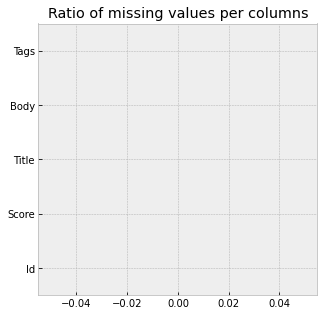

In [8]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [9]:
print('Dupplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [10]:
df.drop(columns=['Id', 'Score'], inplace=True)

# Preprocess Data
Remove special characters from title and body
Remove stop words
Remove HTML tags
Convert characters to lowercase
Lemmatize the words

In [11]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = pp.get_cont_exp(x)
    x = pp.remove_emails(x)
    x = pp.remove_urls(x)
    x = pp.remove_html_tags(x)
    x = pp.remove_rt(x)
    x = pp.remove_accented_chars(x)
    x = pp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [12]:
def get_clea(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = pp.get_cont_exp(x)
    x = pp.remove_emails(x)
    x = pp.remove_urls(x)
    #x = pp.remove_html_tags(x)
    x = pp.remove_rt(x)
    x = pp.remove_accented_chars(x)
    x = pp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [13]:
df['Title'] = df['Title'].apply(lambda x: get_clea(x))

In [14]:
df['Body'] = df['Body'].apply(lambda x: get_clean(x))

In [15]:
#df.head()

# TAGS

In [16]:
df['Tags'] = df['Tags'].apply(lambda x: x.split())

In [17]:
df.head().reset_index(inplace=True)

In [18]:
#df.head()

In [19]:
flat_list = [item for sublist in df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [20]:
#tags_features

In [21]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [22]:
df['Tags'] = df['Tags'].apply(lambda x: most_common(x))
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)


In [23]:
df.dropna(subset=['Tags'], inplace=True)

In [24]:
df.head()

,Title,Body,Tags
2,aspnet site maps,has anyone got experience creating sqlbased as...,"[sql, asp.net]"
3,function for creating color wheels,this is something i have pseudosolved many tim...,[algorithm]
4,adding scripting functionality to net applicat...,i have a little game written in c it uses a da...,"[c#, .net]"
5,should i use nested classes in this case,i am working on a collection of classes used f...,"[c++, class]"
6,homegrown consumption of web services,i have been writing a few web services for a n...,"[.net, web-services]"


# 1.3 EDA

Here I'll just use some LDA to see if shows any paterns in words and the main topics.

In [25]:
no_topics = 20

In [26]:
text = df['Body']

In [27]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       ngram_range = (1,3),
                                       encoding = 'utf-8',
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000,
                                      stop_words='english')

In [28]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [ ]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

# PART 2: Classical classifiers

2.1 Data preparation

Now our data is almost ready to be put into a classifier. I just need to:

Binarize the tags
Use a TFIDF for body and Title The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [ ]:
X1 = df['Body']
X2 = df['Title']
y = df['Tags']

In [ ]:
y.shape

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [ ]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [ ]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

In [ ]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [ ]:
X_train.shape

# One vs Rest

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification.

In [ ]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [ ]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

# GridSearch CV on the best classifier

In [ ]:
param_grid = {'estimator__C':[1,10,100,1000]
              }

In [ ]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
CV_svc.fit(X_train, y_train)

In [ ]:
best_model = CV_svc.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

print_score(y_pred, best_model)

# Confusion Matrix

In [ ]:
for i in range(y_train.shape[1]):
    print(multilabel_binarizer.classes_[i])
    print(confusion_matrix(y_test[:,i], y_pred[:,i]))
    print("")

# Exctracting feature importance

In [ ]:
def print_top10(feature_names, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("--------------------------------------------")
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        print("--------------------------------------------")

In [ ]:
feature_names = vectorizer_X1.get_feature_names() + vectorizer_X2.get_feature_names()


In [ ]:
print_top10(feature_names, best_model, multilabel_binarizer.classes_)


In [ ]:
#https://www.kaggle.com/miljan/predicting-tags-for-stackoverflow